## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [3]:
## load universe_factors
universe = pd.read_csv('factor_data/all_108_zscore.csv')
universe['date'] = pd.to_datetime(universe['trade_date'],format='%Y%m%d')
universe.set_index(['date'],inplace=True)
universe = universe.loc[universe['trade_date']>20190401]
universe = universe.fillna(0.)
universe.head()

,ts_code,trade_date,name,industry,close,log-ret,ind_val,alpha_kama,alpha_atr14,alpha_083,...,alpha_atr,alpha_010,alpha_supertrend,alpha_021,alpha_056,alpha_149,alpha_075,alpha_089,alpha_122,alpha_069
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,603229.SH,20190402,奥翔药业,化学制药,6.61746,0.000000,1,-0.339364,0.862826,-0.342154,...,0.803438,0.966082,0.015803,-0.158525,0.0,-0.095540,-0.039351,-0.047439,-0.828318,-1.000000
2019-04-02,600976.SH,20190402,健民集团,中成药,17.62527,0.030098,1,-0.301341,0.348709,0.485426,...,0.284494,0.384109,-0.061135,-0.167716,0.0,0.269646,0.287179,0.897312,0.288353,0.178962
2019-04-02,600750.SH,20190402,江中药业,中成药,10.37138,-0.010368,1,-0.285253,0.989237,0.310004,...,0.922845,0.824687,0.052673,-0.244220,0.0,1.000000,1.000000,0.129178,0.582776,1.000000
2019-04-02,603811.SH,20190402,诚意药业,化学制药,9.21511,-0.009827,1,-0.296284,0.820945,-0.280557,...,0.790608,0.875617,0.020726,-0.175442,0.0,0.290598,0.287179,-1.000000,0.010272,0.042720
2019-04-02,600513.SH,20190402,联环药业,化学制药,7.53252,0.001273,1,-0.292343,0.902662,0.146276,...,0.861538,0.941134,0.036965,-0.172876,0.0,0.444933,0.015071,0.098507,-0.174588,0.190297


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [4]:
all_factors = universe.copy(deep=True)
universe.industry.unique()

array(['化学制药', '中成药', '软件服务', '医药商业', 'IT设备', '互联网', '化工原料', '元器件',
       '生物制药', '医疗保健', '半导体'], dtype=object)

In [5]:
# sector_dict = {'软件服务':1, '医疗保健':2, '化学制药':3, '中成药':4, 'IT设备':5, '互联网':6, '生物制药':7, '化工原料':8,
#        '医药商业':9, '元器件':10, '半导体':11}
sector_dict = {1:1, 0:0}
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['ind_val']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,name,industry,close,log-ret,ind_val,alpha_kama,alpha_atr14,alpha_083,...,alpha_supertrend,alpha_021,alpha_056,alpha_149,alpha_075,alpha_089,alpha_122,alpha_069,sector_1,sector_0
date,,,,,,,,,,,,,,,,,,,,,
2019-04-02,603229.SH,20190402,奥翔药业,化学制药,6.61746,0.000000,1,-0.339364,0.862826,-0.342154,...,0.015803,-0.158525,0.0,-0.095540,-0.039351,-0.047439,-0.828318,-1.000000,True,False
2019-04-02,600976.SH,20190402,健民集团,中成药,17.62527,0.030098,1,-0.301341,0.348709,0.485426,...,-0.061135,-0.167716,0.0,0.269646,0.287179,0.897312,0.288353,0.178962,True,False
2019-04-02,600750.SH,20190402,江中药业,中成药,10.37138,-0.010368,1,-0.285253,0.989237,0.310004,...,0.052673,-0.244220,0.0,1.000000,1.000000,0.129178,0.582776,1.000000,True,False
2019-04-02,603811.SH,20190402,诚意药业,化学制药,9.21511,-0.009827,1,-0.296284,0.820945,-0.280557,...,0.020726,-0.175442,0.0,0.290598,0.287179,-1.000000,0.010272,0.042720,True,False
2019-04-02,600513.SH,20190402,联环药业,化学制药,7.53252,0.001273,1,-0.292343,0.902662,0.146276,...,0.036965,-0.172876,0.0,0.444933,0.015071,0.098507,-0.174588,0.190297,True,False


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [6]:
quantile_jud = all_factors['log-ret'].quantile([0.3,0.7,1.])
quantile_jud

0.3   -0.012497
0.7    0.011042
1.0    0.258654
Name: log-ret, dtype: float64

In [7]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<=-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>=0.01, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [8]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int16)

In [9]:
all_factors['target'].unique()
#all_factors.loc[all_factors['target']==0].trade_date.unique()

array([ 0,  1, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

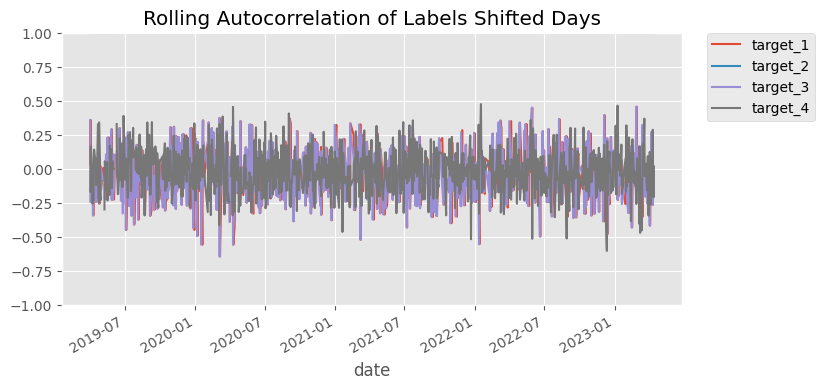

In [10]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220701]
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [11]:
features = [
            'alpha_kama', 'alpha_atr14', 'alpha_083', 'alpha_103',  'alpha_111', 'alpha_021',
            'alpha_pb',  'alpha_101', 'alpha_atr', 'alpha_010',  'alpha_supertrend',
            'alpha_056', 'alpha_149', 'alpha_075', 'alpha_089','alpha_122', 'alpha_069'
            ] + sector_columns

target_label = 'target'
print(all_factors.shape)

(86485, 31)


In [12]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
print(all_factors.shape)
all_factors.head()

(86053, 31)


trade_date  name industry     close   log-ret  ind_val  \
date       ts_code                                                             
2019-04-02 603229.SH    20190402  奥翔药业     化学制药   6.61746  0.000000        1   
           300130.SZ    20190402   新国都     IT设备  17.25216 -0.017690        0   
           002365.SZ    20190402  永安药业     化学制药  12.18768  0.051210        1   
           300677.SZ    20190402  英科医疗     医疗保健   6.80152 -0.007667        1   
           002728.SZ    20190402  特一药业      中成药  14.63952  0.008973        1   

                      alpha_kama  alpha_atr14  alpha_083  alpha_103  ...  \
date       ts_code                                                   ...   
2019-04-02 603229.SH   -0.339364     0.862826  -0.342154  -0.535638  ...   
           300130.SZ   -0.348036    -0.065501   0.280766  -0.410541  ...   
           002365.SZ   -0.299480     0.511945   0.719323   0.305151  ...   
           300677.SZ   -0.304666     0.854512   0.081954   1.000000  ...   
           002728.SZ   -0.308610     0.522473  -0.099187  -0.186697  ...   

                      alpha_122  alpha_069  sector_1  sector_0  return_2q  \
date       ts_code                                                          
2019-04-02 603229.SH  -0.828318  -1.000000      True     False          0   
           300130.SZ  -0.251014   0.091671     False      True         -1   
           002365.SZ   0.338191   0.109716      True     False          1   
           300677.SZ   0.214330   0.081865      True     False          0   
           002728.SZ   0.028700  -0.292329      True     False          0   

                      target  target_1  target_2  target_3  target_4  
date       ts_code                                                    
2019-04-02 603229.SH       0       0.0       0.0      -1.0       0.0  
           300130.SZ      -1       0.0      -1.0      -1.0      -1.0  
           002365.SZ       1       0.0       1.0       1.0      -1.0  
           300677.SZ       0       1.0       0.0       1.0       1.0  
           002728.SZ       1       0.0       1.0       0.0       1.0  

[5 rows x 31 columns]

In [13]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.8, 0.15, 0.05)

X_valid.tail()

alpha_kama  alpha_atr14  alpha_083  alpha_103  \
date       ts_code                                                    
2023-02-02 301041.SZ   -0.273155     0.335291   0.020209   0.632660   
           002987.SZ   -0.357999    -0.022950   0.001415  -1.000000   
           002577.SZ   -0.293011     0.834608   0.011547  -1.000000   
           603258.SH   -0.331554     0.376779  -0.278199  -0.607520   
           688117.SH   -0.498738    -0.015456   0.009015  -0.701913   

                      alpha_111  alpha_021  alpha_pb  alpha_101  alpha_atr  \
date       ts_code                                                           
2023-02-02 301041.SZ  -0.116172   0.110395 -0.062341  -1.000000   0.410145   
           002987.SZ  -0.120919   0.003214 -0.325068   0.857178  -0.013532   
           002577.SZ  -0.126344  -0.017284 -0.035207   0.943239   0.721240   
           603258.SH  -0.086452  -0.001024  0.291716   0.924762   0.203923   
           688117.SH  -0.061151   0.010740  0.229001  -1.000000  -0.036546   

                      alpha_010  alpha_supertrend  alpha_056  alpha_149  \
date       ts_code                                                        
2023-02-02 301041.SZ   0.676001         -0.222432       -1.0  -0.479076   
           002987.SZ   0.131793         -0.201190       -1.0  -0.091348   
           002577.SZ   0.900267          0.247071       -1.0   0.442280   
           603258.SH   0.452438          0.032320       -1.0  -0.704436   
           688117.SH   0.348473          0.182384       -1.0  -0.145765   

                      alpha_075  alpha_089  alpha_122  alpha_069  sector_1  \
date       ts_code                                                           
2023-02-02 301041.SZ  -0.020921   0.020793   0.117814  -0.302672     False   
           002987.SZ  -0.246862   0.220311  -0.024329  -0.104587     False   
           002577.SZ   0.160622   0.063344  -0.157507  -0.300670     False   
           603258.SH   0.906736   0.010962  -0.212243  -0.465493     False   
           688117.SH  -0.246862   0.025500  -0.207448  -0.249238      True   

                      sector_0  
date       ts_code              
2023-02-02 301041.SZ      True  
           002987.SZ      True  
           002577.SZ      True  
           603258.SH      True  
           688117.SH     False

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [14]:
X_train.head()

alpha_kama  alpha_atr14  alpha_083  alpha_103  \
date       ts_code                                                    
2019-04-02 603229.SH   -0.339364     0.862826  -0.342154  -0.535638   
           300130.SZ   -0.348036    -0.065501   0.280766  -0.410541   
           002365.SZ   -0.299480     0.511945   0.719323   0.305151   
           300677.SZ   -0.304666     0.854512   0.081954   1.000000   
           002728.SZ   -0.308610     0.522473  -0.099187  -0.186697   

                      alpha_111  alpha_021  alpha_pb  alpha_101  alpha_atr  \
date       ts_code                                                           
2019-04-02 603229.SH  -0.000345  -0.158525 -0.043900        0.0   0.803438   
           300130.SZ  -0.057061  -0.155892 -0.011165        0.0  -0.045318   
           002365.SZ  -0.042667  -0.198582  0.734977        0.0   0.408320   
           300677.SZ  -0.076060  -0.635367  0.370192        0.0   0.877063   
           002728.SZ   0.002439  -0.170585  0.140514        0.0   0.487107   

                      alpha_010  alpha_supertrend  alpha_056  alpha_149  \
date       ts_code                                                        
2019-04-02 603229.SH   0.966082          0.015803        0.0  -0.095540   
           300130.SZ   0.389142          0.018103        0.0   0.005489   
           002365.SZ   0.739743         -1.000000        0.0   0.139641   
           300677.SZ   0.962552          0.001708        0.0   0.146956   
           002728.SZ   0.595446          0.025109        0.0   0.157472   

                      alpha_075  alpha_089  alpha_122  alpha_069  sector_1  \
date       ts_code                                                           
2019-04-02 603229.SH  -0.039351  -0.047439  -0.828318  -1.000000      True   
           300130.SZ   0.123914   0.048802  -0.251014   0.091671     False   
           002365.SZ   0.069492   0.037088   0.338191   0.109716      True   
           300677.SZ  -0.311459   0.055772   0.214330   0.081865      True   
           002728.SZ   0.232757   1.000000   0.028700  -0.292329      True   

                      sector_0  
date       ts_code              
2019-04-02 603229.SH     False  
           300130.SZ      True  
           002365.SZ     False  
           300677.SZ     False  
           002728.SZ     False

In [21]:
n_days = 50
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 200,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [10, 20, 22]

### Pick Important Features by Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.24s/Model]


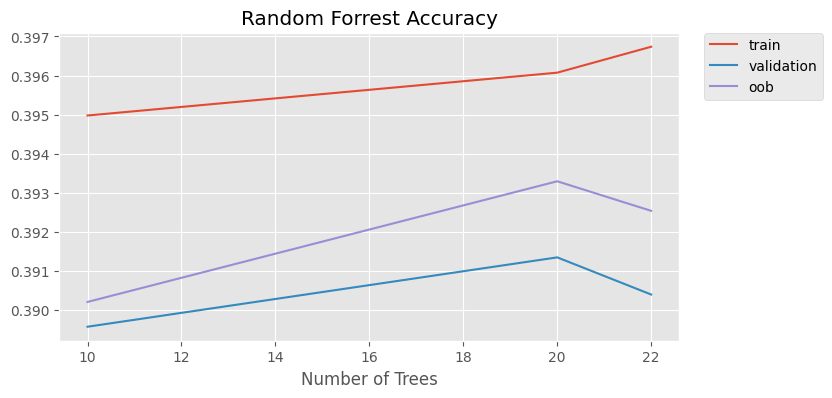

Features Ranked by Average Importance:

      Feature              Importance
 1. alpha_pb         (0.26162486486432696)
 2. alpha_atr14      (0.2000550741805274)
 3. alpha_122        (0.14046669306223705)
 4. alpha_atr        (0.1057124666627381)
 5. alpha_075        (0.09426609966304321)
 6. alpha_103        (0.08941876498882523)
 7. alpha_056        (0.050260587444927445)
 8. alpha_149        (0.03329819929456391)
 9. sector_1         (0.008669564406090515)
10. sector_0         (0.004435613108904745)
11. alpha_069        (0.0041666725294409535)
12. alpha_083        (0.0028401731755724365)
13. alpha_kama       (0.001807510882556411)
14. alpha_010        (0.0017956266660540416)
15. alpha_supertrend (0.0008243568064302504)
16. alpha_111        (0.0003577322637613528)
17. alpha_021        (0.0)
18. alpha_101        (0.0)
19. alpha_089        (0.0)


In [23]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=3):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [31]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    #'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [10, 20, 30]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 3/3 [00:05<00:00,  1.89s/Model]


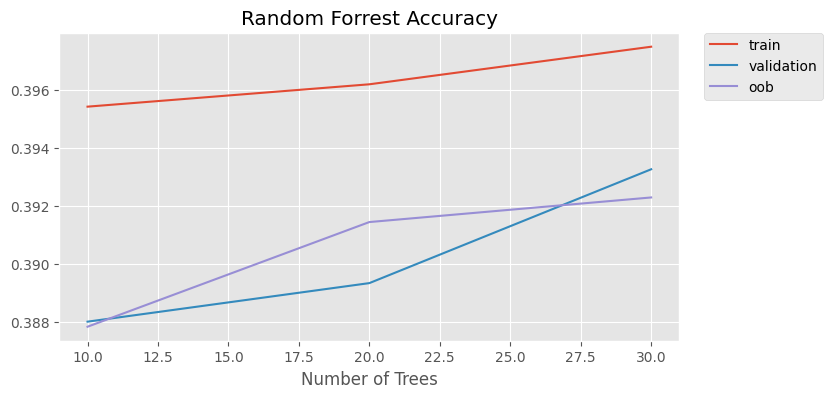

In [32]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.3932527375150326
Precision score:  0.3932527375150326
Recall score:  0.3932527375150326
F1 score:  0.3932527375150326


In [34]:
factor_names = [ 
            'alpha_kama', 'alpha_atr14', 'alpha_083', 'alpha_103',  'alpha_111', 'alpha_021',
            #'alpha_pb',  'alpha_101', 'alpha_atr', 'alpha_010',  'alpha_supertrend',
            #'alpha_056', 'alpha_149', 'alpha_075', 'alpha_089','alpha_122', 'alpha_069'
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [37]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # only for long factor evaluate
    #for name in (factors + [alpha_score_label]):
    #    factors_with_alpha[name] = np.where(factors_with_alpha[name]>0, factors_with_alpha[name], 0.)
        
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=2)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 21.2% entries from factor data: 0.0% in forward returns computation and 21.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

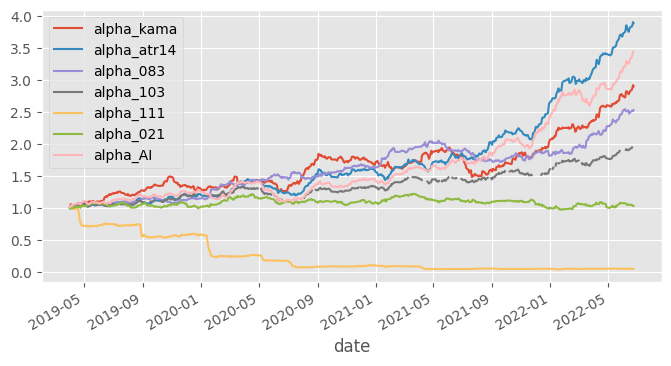

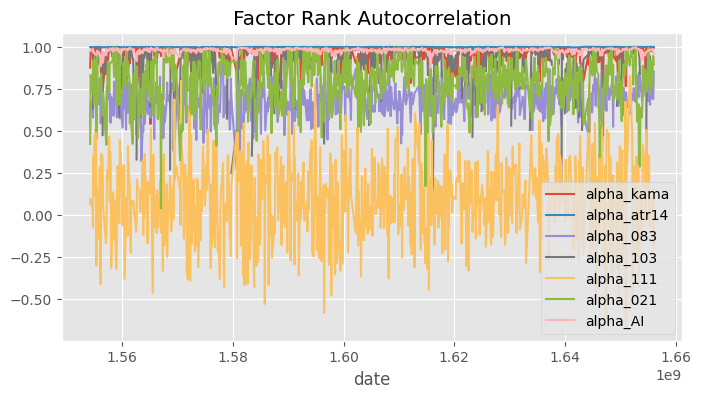

In [38]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 20.4% entries from factor data: 0.0% in forward returns computation and 20.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

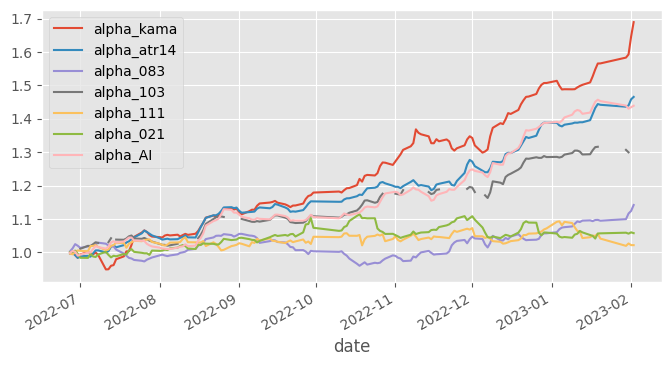

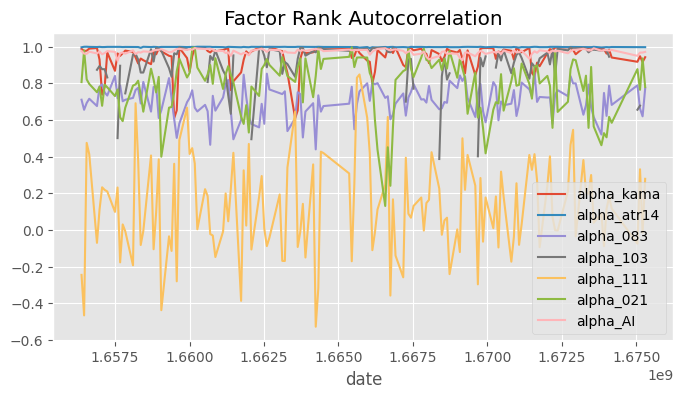

In [39]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [40]:
n_days = 20
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 100,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 30

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [41]:
print(train_score)
print(valid_score, oob_score)

[0.3966756098313134]
[0.3958478384707893] [0.39384775655495313]


### View Train Set Results

Cleaning Data...

Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 53.1% entries from factor data: 2.0% in forward returns computation and 51.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.0% entries from factor data: 2.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

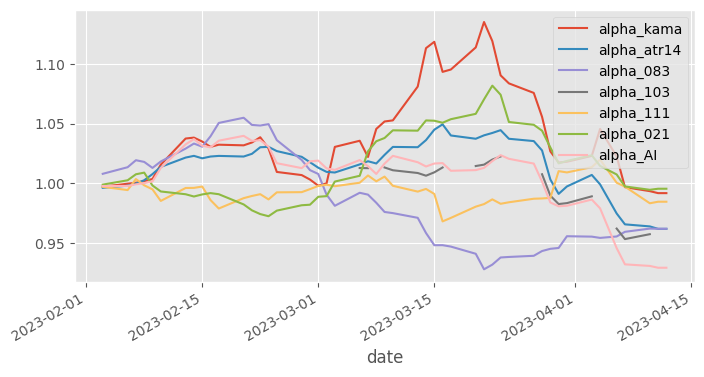

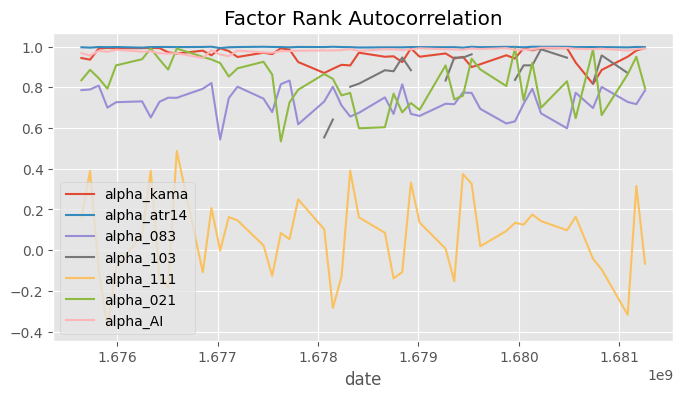

In [42]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 23.0% entries from factor data: 0.1% in forward returns computation and 22.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exce

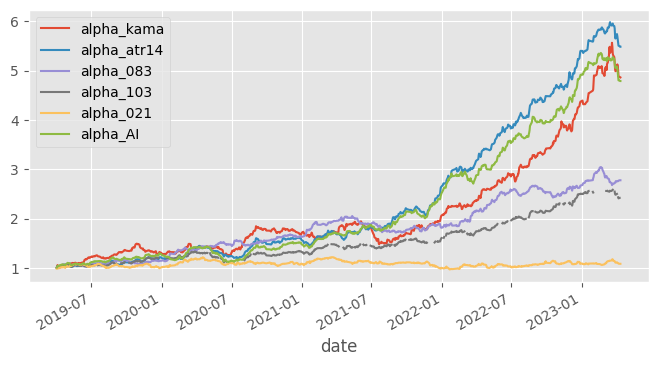

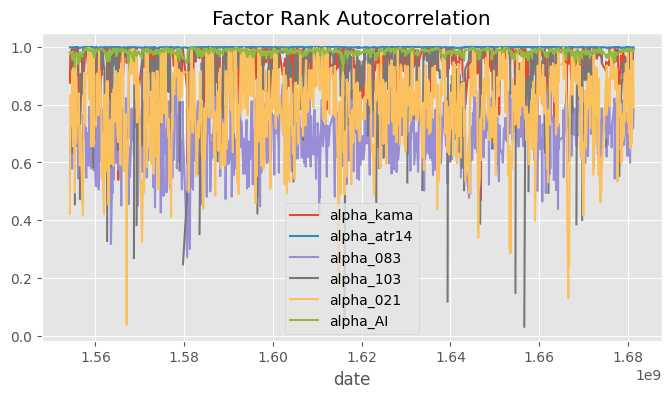

In [45]:
factor_names = [
           'alpha_kama', 'alpha_atr14', 'alpha_083', 'alpha_103',  'alpha_021', #'alpha_111', 
            #'alpha_pb',  'alpha_101', 'alpha_atr', 'alpha_010',  'alpha_supertrend',
            #'alpha_056', 'alpha_149', 'alpha_075', 'alpha_089','alpha_122', 'alpha_069'
           ]
tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([tmp, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [46]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
#     factors_with_alpha = factors_with_alpha.reset_index()
#     factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
#     factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha

sample_all = universe.reset_index()
sample_all.set_index(['date','ts_code']).sort_values(by=['date'])
save_factors = save_AI_factors(sample_all, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[-0.03254746 -0.0127851   0.01054886 ... -0.05726117  0.01223626
 -0.0617169 ] 86485


<AxesSubplot:>

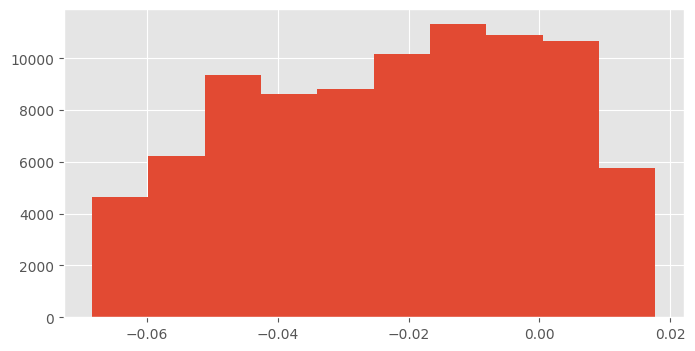

In [47]:
save_factors['alpha_AI'].hist()

In [48]:
#save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
         'alpha_atr14', 'alpha_kama', 'alpha_AI'
        ]
save_factors[field].to_csv('AI_data/factors_AI_108.csv')

### Save RandomForest Model

In [49]:
import joblib

joblib.dump(clf_nov, 'AI_data/clf_108.pkl')


['AI_data/clf_108.pkl']

Load model example

In [ ]:
clf_load = joblib.load('clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
print(alpha_score, len(alpha_score))